# Machine learning: a very quick primer

This post will introduce the basic fundamentals of two popular machine learning (ML) tools: PyTorch and TensorFlow. Instead of introducing the academic basis for this question, which would be much more appropriate for a proper lecture, we will formulate a few simple examples to demonstrate the basic patterns for solving problems with ML. In particular, we will start with a simple linear regression to connect the ML methods with a very common statistical inference. While we formulate these problems, we will also review the best practices for deploying ML codes on *Blue Crab*.

## Using ML and GPU accelerators on *Blue Crab*

As of this writing (December 2019) we have not yet upgraded the CUDA drivers on *Blue Crab* because we are preparing a pending driver and kernel update. For this reason, users must very carefully control their software versions. Thankfully, we already know how to do this [using custom conda environments](https://marcc-hpc.github.io/esc/common/python-environments#conda). 

For the following exercise, we will install PyTorch version 1.3 which has been compiled against CUDA 9.2 using the following environment file. After consulting the [TensorFlow compatibility charts]() we have also selected version 1.12, which is the latest version compatible with CUDA 9.2. Since this version of TensorFlow requires Python 3.6, we have also requested that version in our `requirements.yaml` file.

~~~
name: ml
dependencies:
  - python<3.7
  - pytorch::torchvision
  - pytorch::pytorch=1.3=*cuda9.2*
  - matplotlib
  - numpy
  - scipy
  - jupyter
  - tensorflow==1.12
  - scikit-learn
  - pandas
  - seaborn
  - pip
  - pip:
    - torchviz
    - git+https://github.com/tensorflow/docs
~~~

Note that this environment may be precompiled before class.

## Linear regression with PyTorch

In this section we will use PyTorch to perform a simple linear regression. This might seem like "fishing with dynamite" but the connection between a familiar regression and the vast ML infrastructure is fairly direct and work understanding in detail.

The code in this section tracks a [this useful tutorial](https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e).

Before starting with PyTorch we will perform a simple linear regression using some synthetic data.

In [1]:
import numpy as np

# set the random seed
np.random.seed(42)
x = np.random.rand(100, 1)
y = 1 + 2 * x + .1 * np.random.randn(100, 1)

# shuffle the data
idx = np.arange(100)
np.random.shuffle(idx)

# divide the data into training and testing sets
train_idx = idx[:80]
val_idx = idx[80:]
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

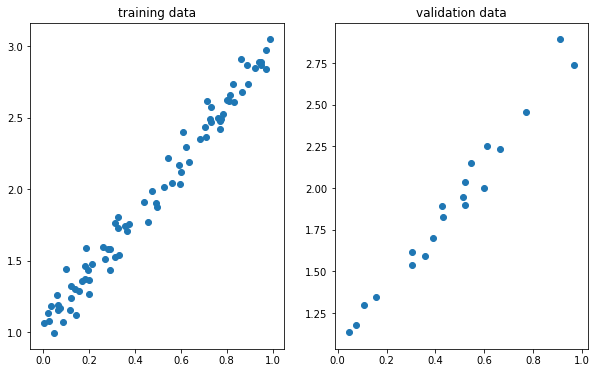

In [2]:
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(121)
ax.set_title('training data')
ax.scatter(x_train,y_train)
ax = fig.add_subplot(122)
ax.set_title('validation data')
ax.scatter(x_val,y_val)
plt.show()

### Gradient descent

To perform this regression, we will use the *gradient descent* optimization algorithm. In short, [this method iteratively searches for a local minimum](https://en.wikipedia.org/wiki/Gradient_descent) of a function by taking steps in the direction of the negative gradient at the current point. You can think of it like walking downhill along the steepest downward path. The procedure includes three steps: 

1. estimate the loss
2. compute the gradients
3. update our parameters

We repeat this until we think we have found a minimum. The number of sample points determines if we are performing a stochastic ($1$), mini-batch ($<N$), or batch ($N$) gradient descent.

Our model for the data is: $y = a + b x + \epsilon$ where $\epsilon$ is random noise. For a linear regression, we define the error $E$ or *loss function* as the mean squared error (or MSE) given below.

$$
\begin{aligned}
E &= \frac{1}{N} \sum_{i=1}^{N}{({y_i - \hat{y_i}})^{2}} \\
E &= \frac{1}{N} \sum_{i=1}^{N}{(y_i - a - bx_i)^{2}}
\end{aligned}
$$

The gradients, which tell us how the error changes as we vary each parameter, depend on the partial deriviatves, which can be computed with the chain rule.

$$
\begin{aligned}
E &= \frac{\partial E}{\partial a} = \frac{\partial E}{\partial \hat{y_i}} \cdot \frac{\partial \hat{y_i}}{\partial a} = \frac{1}{N} \sum_{i=1}^{N} {2(y_i-a-bx_i)\cdot(-1)} = -2 \frac{1}{N} \sum_{i=1}^{N} {(y_i - \hat{y_i})} \\
E &= \frac{\partial E}{\partial b} = \frac{\partial E}{\partial \hat{y_i}} \cdot \frac{\partial \hat{y_i}}{\partial b} = \frac{1}{N} \sum_{i=1}^{N} {2(y_i-a-bx_i)\cdot(-x_i)} = -2 \frac{1}{N} \sum_{i=1}^{N} {x_i (y_i - \hat{y_i})} \\
\end{aligned}
$$

Lastly, we update according to a learning rate $\eta$ using these definitions.

$$
\begin{aligned}
a &= a - \eta \frac{\partial E}{\partial a} \\
b &= b - \eta \frac{\partial E}{\partial b} \\
\end{aligned}
$$

The choice of loss function, calculation of the gradient, and update method are the key ingredients for implementing this optimization. The following code is comparatively simple.

In [3]:
# random starting point
np.random.seed(42)
a = np.random.randn(1)
b = np.random.randn(1)
print(a, b)

# choose a learning rate and size of the training loop
lr = 1e-1
n_epochs = 1000

# training loop
for epoch in range(n_epochs):
    # current estimate/prediction
    yhat = a + b * x_train
    # error between prediction and  training data
    error = (y_train - yhat)
    # compute the loss function (MSE)
    loss = (error ** 2).mean()
    # compute the gradients
    a_grad = -2 * error.mean()
    b_grad = -2 * (x_train * error).mean()
    # update the parameters via learning rate and gradient
    a = a - lr * a_grad
    b = b - lr * b_grad
    
print(a, b)

[0.49671415] [-0.1382643]
[1.02354094] [1.96896411]


The results above show the initial random guess followed by the result of the optimization. Next we will check the results of our basic regression using `scikit-learn`, which provides a single function to perform the regression. We can see that the results are nearly identical.

In [4]:
from sklearn.linear_model import LinearRegression
linr = LinearRegression()
linr.fit(x_train, y_train)
print(linr.intercept_, linr.coef_[0])

[1.02354075] [1.96896447]


Prepare to use PyTorch by loading the libraries and selecting a device. In the remainder of the tutorial, we will offload our work to the GPU if one exists. Note that using the GPUs on *Blue Crab* may require special instructions which will be discussed in class. In particular, it may be necessary to load a very specific version of PyTorch which is built against our current maximum CUDA toolkit version, which is itself set by the device drivers on our machine.

In [5]:
import torch
import torch.optim as optim
import torch.nn as nn
from torchviz import make_dot

# select the GPU if possible
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

Note that PyTorch allows you to convert `numpy` objects and also send them directly to your GPU device. PyTorch manages its own data types. We use the following techniques later in the exercise when we build the regression in PyTorch.

In [6]:
# move the data to the GPU
x_train_tensor = torch.from_numpy(x_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)
print(type(x_train), type(x_train_tensor), x_train_tensor.type())

<class 'numpy.ndarray'> <class 'torch.Tensor'> torch.FloatTensor


A PyTorch tensor is an implementation of the standard (mathematical) tensor which allows you to easily compute its gradients. This radically simplifies the process of building machine learning models because it saves you the effort of deriving the update procedure manually.

In [7]:
lr = 1e-1
n_epochs = 1000

torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    error = y_train_tensor - yhat
    loss = (error ** 2).mean()
    # gradients are automatically computed
    loss.backward()
    # note that the loss function generates the grad
    with torch.no_grad():
        a -= lr * a.grad
        b -= lr * b.grad
    # we have to clear these for the next step
    a.grad.zero_()
    b.grad.zero_()

print(a, b)

tensor([1.0235], requires_grad=True) tensor([1.9690], requires_grad=True)


We can inspect the dynamic computation graph for this model. In the following diagram, blue boxes are tensors with computable gradients, the gray boxes represent Python operations, and the green boxes are the starting points for the computation of gradients. The resulting map shows us how the `backward` function infers the gradients for tensors with the `requires_grad` flag set at construction.

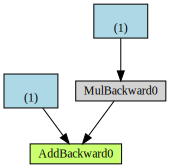

In [8]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
yhat = a + b * x_train_tensor
error = y_train_tensor - yhat
loss = (error ** 2).mean()
make_dot(yhat)

 This analysis gives us useful insights into the construction of more complex models. We can refine the training procedure further by replacing our manual update steps with the use of a proper optimizer.

In [9]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

lr = 1e-1
n_epochs = 1000

# choose an optimizer
optimizer = optim.SGD([a, b], lr=lr)

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    error = y_train_tensor - yhat
    loss = (error ** 2).mean()
    loss.backward()    
    # use the optimizer to perform the updates
    optimizer.step()
    optimizer.zero_grad()
    
print(a, b)

tensor([1.0235], requires_grad=True) tensor([1.9690], requires_grad=True)


Our linear regression uses the standard mean-squared error (MSE) as the loss function, however many other machine learning models use alternate loss functions, many of which lack an analytical solution. 

In [12]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

lr = 1e-1
n_epochs = 1000

# define a loss function and optimizer
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD([a, b], lr=lr)

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    loss = loss_fn(y_train_tensor, yhat)
    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()
    
print(a, b)

tensor([1.0235], requires_grad=True) tensor([1.9690], requires_grad=True)


The remainder of the [source material](https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e) for this post dives deeper into the process of building these kinds of regressions. For now, we will turn to Tensorflow for a similar exercise.

## Tensorflow and Keras

There are many competing frameworks for performing ML on your data. Tensorflow provides a useful alternative. The following exercise performs a similer, but higher dimensional regression based on the [documentation here](https://www.tensorflow.org/tutorials/keras/regression). First we must import a number of libraries, including the abstraction layer *Keras* which makes it easier to work with Tensorflow. Keras is an API which can use multiple ML drivers, sometimes called back ends.

In [13]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

First we will prepare some data. In this example, we will attempt to predict the fuel efficiency of cars build in the 1970s and 80s using attributes like the number of cylinders, displacement, horsepower, and weight. Use the following commands to collect the data.

In [16]:
dataset_path = keras.utils.get_file("auto-mpg.data", 
    "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/Users/rpb/.keras/datasets/auto-mpg.data'

In [18]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


We can inspect some of the features of the data, and clean the data by removing incomplete records.

In [21]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [22]:
dataset = dataset.dropna()

We further clean the data by mapping the origin column to separate categories.

In [23]:
dataset['Origin'] = dataset['Origin'].map(lambda x: {1: 'USA', 2: 'Europe', 3: 'Japan'}.get(x))

In [24]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


Next we will split the data into training and testing sets.

In [25]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

The seaborn pair plot allows us to inspect the correlations between four columns in our data set (off axis) along with their distributions (diagonal).

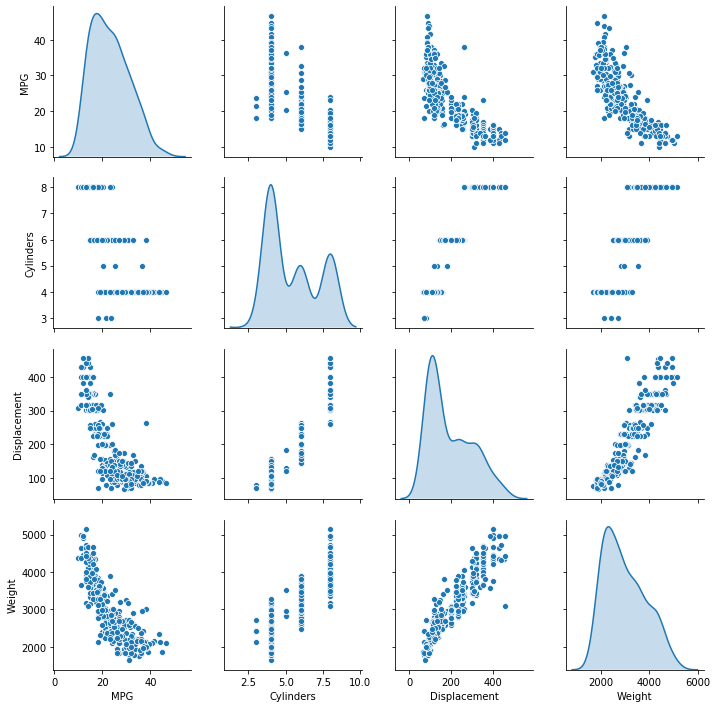

In [26]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

We can also collect summary statistics.

In [27]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


Before continuing, we must separate the *labels* from the *features* in order to make our predictions.

In [33]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

We also normalize the data because they all use different numerical ranges. This typically helps with convergence.

In [34]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

We are finally ready to build the model. In the following function we will generate a `Sequential` model with two densely connected hidden layers along with an output layer that returns a single continuous value. We wrap the model in a function for later.

In [35]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
        optimizer=optimizer,
        metrics=['mae', 'mse'])
    return model

In [36]:
model = build_model()

In [37]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


To test the model, we can take 10 examples from our training data and use `model.predict`.

In [38]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[0.14024973],
       [0.15446681],
       [0.07823651],
       [0.08530468],
       [0.30942103],
       [0.23088537],
       [0.37081474],
       [0.03645729],
       [0.22059843],
       [0.30308604]], dtype=float32)

To train all of the data, we iterate over smaller batches. One epoch represents a single iteration over *all* of the data. 

In [39]:
EPOCHS = 1000
history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split = 0.2, verbose=0)

After the training is complete, we can inspect the history. Note that the [tensorflow tutorial](https://www.tensorflow.org/tutorials/keras/regression) includes a useful set of callbacks for viewing the results. These are not available for our version of tensorflow, but we will discuss them in class.

In [40]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
995,9.490661,2.434818,9.490661,2.585021,1.045370,2.585021,995
996,9.364464,2.404208,9.364464,2.392526,0.978031,2.392526,996
997,9.934777,2.476030,9.934777,2.339362,0.990820,2.339362,997
998,9.749488,2.503732,9.749488,2.428867,0.997238,2.428867,998
999,9.696823,2.466403,9.696823,2.400815,0.975567,2.400815,999


We can compare our test predictions with the labels and also view the error distribution.

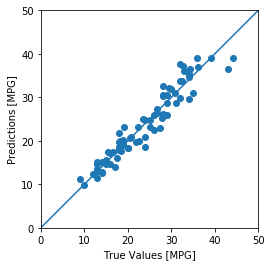

In [41]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

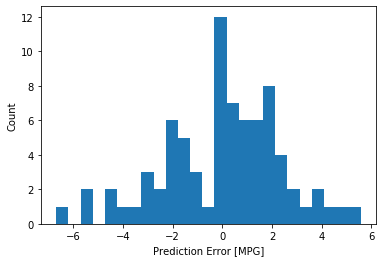

In [42]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

The workflow above includes many of the same components as our first example, however much of the design of our algorithm has been compartmentalized in the `keras.Sequential` function. The question of which API or framework or library is best for your research may be partly a matter of taste and partly determined by your technical needs. In our final exercise, we will return to Pytorch to perform an image classification, which provides a more complex model compared to the regression we started with.

## Image classification with PyTorch

The following exercise comes directly from the [PyTorch documentation](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html). In this section we will classify images from the `CIFAR10` dataset. Classification and regression are the two main types of *supervised* learning.

In [43]:
import torch
import torchvision
import torchvision.transforms as transforms

We will start by downloading the data.

In [44]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True,
    download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=4,
    shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False,
    download=True, transform=transform)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=4,
    shuffle=False, num_workers=2)

classes = (
    'plane', 'car', 'bird', 'cat',
    'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [55]:
len(trainloader)

12500

We can plot a few representative images.

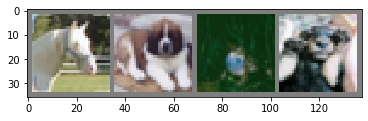

horse   dog  frog   dog


In [45]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

def imshow(img):
    # unnormalize
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Next we will build the model by building a `nn.Model` class and constructing the `forward` function. In the following example we have built a convolutional neural network.

In [46]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

Next we will select the classification cross-entropy loss function along with stochastic gradient descent (SGD) with momentum.

In [47]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

The training loop is very similar to the one we started with: we compute the error, backpropagate, and then update our optimizer. We train for two epochs, each of which coversa all of the data in the `trainloader` object.

In [48]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        # print every 2000 mini-batches
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training')

[1,  2000] loss: 2.187
[1,  4000] loss: 1.874
[1,  6000] loss: 1.707
[1,  8000] loss: 1.607
[1, 10000] loss: 1.547
[1, 12000] loss: 1.504
[2,  2000] loss: 1.449
[2,  4000] loss: 1.391
[2,  6000] loss: 1.370
[2,  8000] loss: 1.339
[2, 10000] loss: 1.332
[2, 12000] loss: 1.294
Finished Training


In [49]:
# save the result
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

We can review some of our predictions by iterating over the test set.

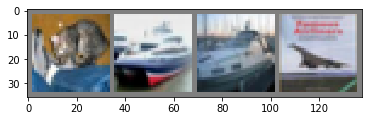

GroundTruth:    cat  ship  ship plane


In [56]:
dataiter = iter(testloader)
images, labels = dataiter.next()
# select some images to review
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [51]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] 
    for j in range(4)))

Predicted:   deer  ship  bird  ship


Overall accuracy is much higher than chance (10% since there are 10 categories).

In [52]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


We can also analyze the resulting predictions to see which images are the hardest to classify.

In [53]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 56 %
Accuracy of   car : 79 %
Accuracy of  bird : 39 %
Accuracy of   cat : 38 %
Accuracy of  deer : 43 %
Accuracy of   dog : 29 %
Accuracy of  frog : 79 %
Accuracy of horse : 56 %
Accuracy of  ship : 73 %
Accuracy of truck : 64 %


We have only scratched the surface so far. The three exercises and corresponding discussions above have ideally emphasized the following important features of ML workflows.

- Machine learning methods have a strong basis in statistical inference, and many statistical questions can be reformulated with machine learning models to interrogate large and complex data sets.
- Machine learning methods perform high-dimensional optimizations of many model parameters.
- Our methods must carefully avoid the perils of overfitting by training and testing on separate data sets.
- The various machine learning tools provide similar levels of abstraction with different methods for formulating the underlying optimization algorithms, loss functions, model structure.
- We should carefully track our software versions so that they are both compatible with our HPC cluster and reproducible.
- Our predictions are only as good as the data!

Users with specific questions about the hardware, software, or best practices for building machine learning models are welcome to contact our staff (`marcc-help@marcc.jhu.edu`) for further advice.